In [10]:
import matplotlib.pyplot as pl
from matplotlib import font_manager
import numpy as np
from geopy.geocoders import Nominatim
import pandas as pd
import json

In [11]:
address = "Selangor, Malaysia"
user_agent_name = f"rooftopApp{np.random.randint(1, 1000)}"
geolocator = Nominatim(user_agent=user_agent_name, timeout=10)
location = geolocator.geocode(address)

data_csv = "C:/Users/User/RooftopCloud/Public/FrontOps/collected_production_data.csv"

df = pd.read_csv(data_csv)
delta_latitude = df["latitude"] - location.latitude
delta_longitude = df["longitude"] - location.longitude
# find index of the closest latitude and longitude
min_index = (delta_latitude**2 + delta_longitude**2).idxmin()
# get the historical data for the closest latitude and longitude
closest_row = df.loc[min_index]
# convert data json into dataframe
data_dict = json.loads(closest_row["data"])
original_data = pd.DataFrame(**data_dict)
historical_data = original_data.copy()



In [ ]:
# extract unique years and months from historical_data
unique_years = historical_data["year"].unique()
unique_months = historical_data["month"].unique()

# create a dataframe with every combination of year and month
year_month_grid = [
    (year, month) for year in unique_years for month in unique_months
]
monthly_data = pd.DataFrame(year_month_grid, columns=["year", "month"])

monthly_data["E_produced"] = 0.0
for i, row in monthly_data.iterrows():
    mask = (historical_data["year"] == row["year"]) & (
        historical_data["month"] == row["month"]
    )
    monthly_data.loc[i, "E_produced"] = np.sum(historical_data.loc[mask, "P"])
    
# convert to sun hours
monthly_data["peak_sun_hours"] = monthly_data["E_produced"] / 500 / 30
    
# Create a new column with "MM/YYYY" labels
monthly_data['date_label'] = monthly_data.apply(
    lambda row: f"{int(row['month']):02d}/{int(row['year'])}", axis=1
)

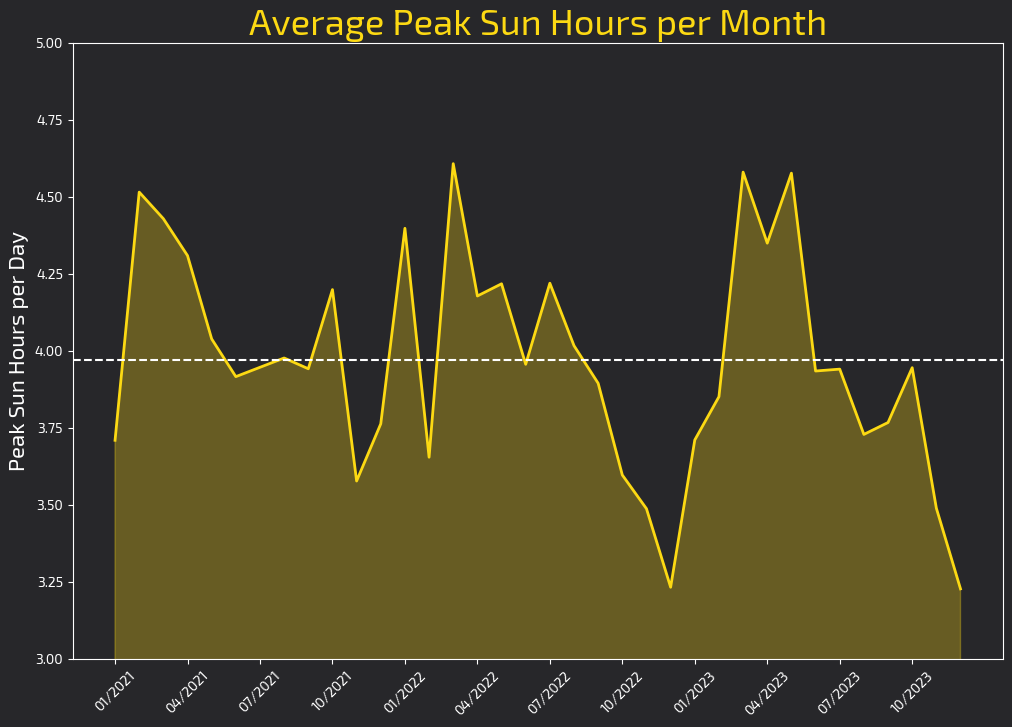

In [33]:
# Plot E_produced using the formatted date as the x-axis
pl.figure(figsize=(12, 8), facecolor='#27272a')
ax = pl.gca()
ax.set_facecolor('#27272a')
pl.rcParams['text.color'] = 'white'
pl.rcParams['axes.labelcolor'] = 'white'
pl.rcParams['axes.edgecolor'] = 'white'
pl.rcParams['xtick.color'] = 'white'
pl.rcParams['ytick.color'] = 'white'
pl.rcParams["font.family"] = "Exo 2"
font_manager.fontManager.addfont('C:/Users/User/Documents/Exo2-VariableFont_wght.ttf')
monthly_data = monthly_data[monthly_data['year'] <= 2023]
pl.plot(monthly_data['date_label'], monthly_data['peak_sun_hours'], linewidth=2, color="#fcd913",alpha=1)
pl.ylim([3,5])
x = monthly_data['date_label']
y = monthly_data['peak_sun_hours']
pl.fill_between(x, y, color="#fcd913", alpha=0.3)
avg_peak = monthly_data['peak_sun_hours'].mean()
pl.axhline(avg_peak, color='white', linestyle='--', label=f'Average: {avg_peak:.2f}')

pl.ylabel("Peak Sun Hours per Day", fontsize=16)
step = 3
indices = np.arange(0, len(monthly_data), step)
pl.xticks(indices, monthly_data['date_label'].iloc[indices], rotation=45)
pl.title("Average Peak Sun Hours per Month", color="#fcd913", fontsize=26, fontweight='bold')
pl.show()
